In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [64]:
df =pd.read_csv('Churn_Modelling.csv')

In [65]:
df.sample(1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9552,9553,15772009,Scott,664,France,Female,41,5,0.0,1,1,1,152054.33,0


In [66]:
df.drop(['RowNumber','CustomerId','Surname'] ,inplace=True, axis=1)

In [67]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [68]:
df.sample()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5966,508,France,Female,43,9,0.0,1,1,0,103726.71,0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [70]:
num_col=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
cat_col=['Geography','Gender']

# Preprocessing

In [71]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler,SMOTE
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
x=df.iloc[:,0:10]
y=df['Exited']
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)


In [73]:
preprocessing=ColumnTransformer([
    ('one_hot_encoding',OneHotEncoder(drop='first',sparse=True,handle_unknown='ignore'),cat_col),
    ('standard_scaler',StandardScaler(),num_col)
])
X_train_trans=preprocessing.fit_transform(X_train)
X_test_trans=preprocessing.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [74]:
smote = SMOTE(random_state=42)
X_train_trans_resample, y_train_resampled = smote.fit_resample(X_train_trans, y_train)

In [75]:
X_train_trans.shape

(8000, 11)

In [76]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout,Dense,BatchNormalization

In [77]:
import keras_tuner as kt

In [78]:
def build_model(hp):
    model =Sequential()
    counter=0
    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        if counter==0:
            model.add(
                Dense(
                    hp.Int('units'+str(i),min_value=8,max_value=128,step=1),activation=hp.Choice('activation'+str(i),values=['relu']),

                    input_dim=11
                )
            )
            model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else:
            model.add(
                Dense(
                    hp.Int('units'+str(i),min_value=1,max_value=128,step=1),
                    activation=hp.Choice('activation'+str(i),values=['relu']),

                )
            )
            model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        counter+=1
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer',values=['adam']),loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [79]:
tuner=kt.RandomSearch(build_model,
                         objective='val_accuracy',
                     max_trials=5,
                     directory='mydir',
                     project_name='hyper_parameter2')


Reloading Tuner from mydir/hyper_parameter2/tuner0.json


In [80]:
tuner.search(X_train_trans,y_train,epochs=5,validation_data=(X_test_trans,y_test))

In [81]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 6,
 'units0': 73,
 'activation0': 'relu',
 'dropout0': 0.1,
 'optimizer': 'adam',
 'units1': 1,
 'activation1': 'relu',
 'dropout1': 0.1,
 'units2': 1,
 'activation2': 'relu',
 'dropout2': 0.1,
 'units3': 1,
 'activation3': 'relu',
 'dropout3': 0.1,
 'units4': 1,
 'activation4': 'relu',
 'dropout4': 0.1,
 'units5': 1,
 'activation5': 'relu',
 'dropout5': 0.1}

In [82]:
tuner.search(X_train_trans,y_train,epochs=5,validation_data=(X_test_trans,y_test))

In [83]:
model=tuner.get_best_models(num_models=1)[0]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [85]:
history=model.fit(X_train_trans,y_train,batch_size=32,epochs=40,initial_epoch=6, validation_data=(X_test_trans,y_test))

Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6936 - loss: 0.6661 - val_accuracy: 0.8035 - val_loss: 0.5795
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7292 - loss: 0.5839 - val_accuracy: 0.8035 - val_loss: 0.5085
Epoch 9/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7784 - loss: 0.5221 - val_accuracy: 0.8035 - val_loss: 0.4629
Epoch 10/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7842 - loss: 0.4920 - val_accuracy: 0.8035 - val_loss: 0.4397
Epoch 11/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7915 - loss: 0.4787 - val_accuracy: 0.8035 - val_loss: 0.4349
Epoch 12/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8074 - loss: 0.4734 - val_accuracy: 0.8035 - val_loss: 0.4179
Epoch 13/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8185 - loss: 0.4501 - val_accuracy: 0.8305 - val_loss: 0.4114
Epoch 14/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8227 - loss: 0.4402 - val_accurac

In [86]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 73)                  │             876 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73)                  │             292 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              74 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,506 (13.70 KB)

 Trainable params: 1,116 (4.36 KB)

 Non-trainable params: 156 (624.00 B)

 Optimizer params: 2,234 (8.73 KB)

In [87]:
y_pred = model.predict(X_test_trans)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [88]:
y_pred = y_pred.argmax(axis=-1)

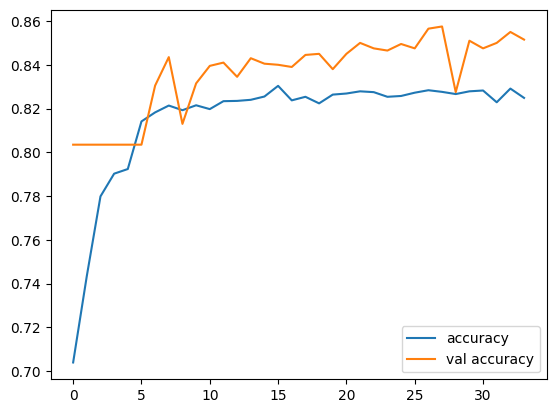

In [89]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.legend()

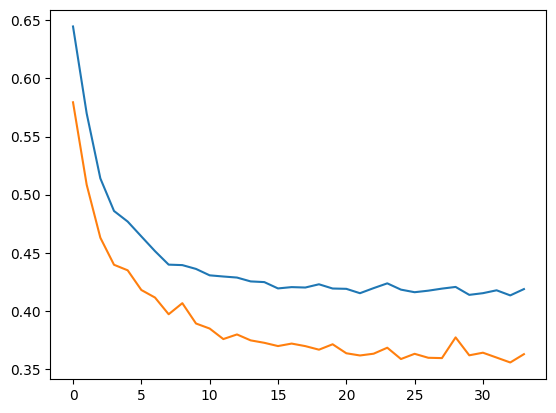

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [91]:
#model2

In [92]:
model1=Sequential()
model1.add(Dense(12,activation='sigmoid',input_dim=11 ))
model1.add(BatchNormalization())
model1.add(Dense(12,activation='sigmoid'  ))
model1.add(Dropout(0.5))
model1.add(Dense(12,activation='sigmoid'  ))
model1.add(Dropout(0.3))
model1.add(Dense(10,activation='sigmoid'  ))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(Dense(5,activation='sigmoid'  ))
model1.add(Dropout(0.8))
model1.add(Dense(3,activation='sigmoid'  ))
model1.add(Dense(1,activation='sigmoid'  ))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [93]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 12)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12)                  │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 3)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751 (2.93 KB)

 Trainable params: 707 (2.76 KB)

 Non-trainable params: 44 (176.00 B)

In [98]:
model1.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [95]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [99]:
history=model1.fit(X_train_trans,y_train,validation_data=(X_test_trans, y_test),batch_size=32,epochs=40,validation_split=0.2,verbose=1)

Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3653 - loss: 0.7545 - val_accuracy: 0.8035 - val_loss: 0.5920
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7874 - loss: 0.5834 - val_accuracy: 0.8035 - val_loss: 0.5157
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8013 - loss: 0.5238 - val_accuracy: 0.8035 - val_loss: 0.4982
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7937 - loss: 0.5155 - val_accuracy: 0.8035 - val_loss: 0.4948
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7978 - loss: 0.5062 - val_accuracy: 0.8035 - val_loss: 0.4931
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7896 - loss: 0.5149 - val_accuracy: 0.8035 - val_loss: 0.4895
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8006 - loss: 0.4980 - val_accuracy: 0.8035 - val_loss: 0.4832
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7965 - loss: 0.5002 - val_accuracy: 0.

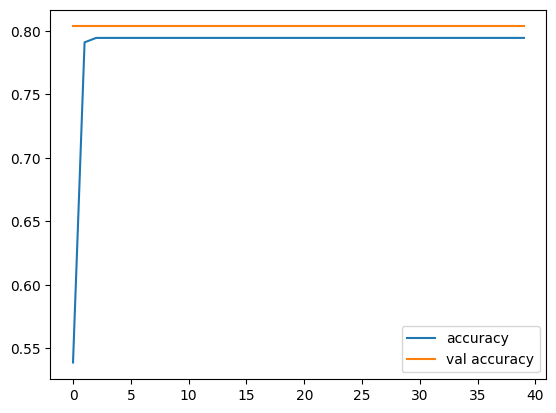

In [101]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.legend()

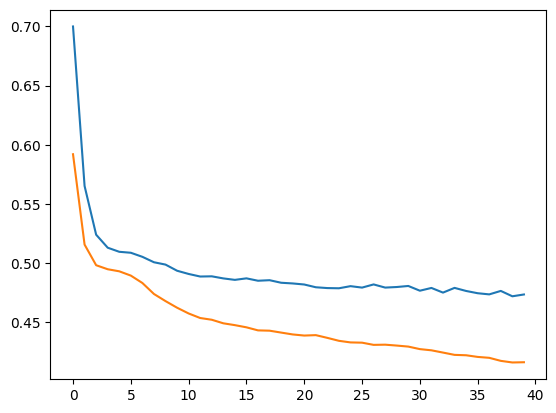

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [103]:
import pickle
pickle.dump(preprocessing,open('preprocessor.pkl','wb'))

In [104]:
model.save('my_model.h5')

In [105]:
X_train.sample()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6447,619,Spain,Female,31,3,141751.82,1,0,1,61531.86


In [110]:
X_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,651.647625,38.897750,5.003875,76102.139645,1.531375,0.703500,0.512750,100431.289764
std,96.366200,10.518953,2.881822,62461.005757,0.579705,0.456743,0.499869,57518.920431
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000
25%,585.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51364.125000
50%,653.000000,37.000000,5.000000,96447.520000,1.000000,1.000000,1.000000,100487.720000
75%,719.000000,44.000000,7.000000,127611.332500,2.000000,1.000000,1.000000,149595.842500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000


In [113]:
X_train['CreditScore'].min()

350

In [115]:
X_train['Geography'].value_counts()

,count
Geography,
France,3994
Germany,2011
Spain,1995
